## Working with Inception architecture

In [1]:
from model import create_model
nn4_small2 = create_model()

In [ ]:
nn4_small2.summary()

In [ ]:
from keras import backend as K
from keras.layers import Input, Layer
from keras.models import Model

# Anchor, +ve, -ve Input
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

#Embedding vectors
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a,p,n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss
    
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])
# Model to be trained with A, P, N images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [ ]:
nn4_small2_train.summary()

In [ ]:
from data import triplet_generator

generator = triplet_generator()

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

## Working with OpenFace Model

In [2]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

In [3]:
# Preparing the dataset
import os.path
import numpy as np

class Metadata():
    def __init__(self, base, name, file):
        self.base = base
        self.name = name
        self.file = file
        
    def __repr__(self):
        return self.image_path()
    
    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for j in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(j)[1]
            if ext=='.jpg' or ext == '.jpeg':
                metadata.append(Metadata(path, i, j))
    return np.array(metadata)

In [4]:
metadata = load_metadata('dataset')

In [7]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]

alignment = AlignDlib('models/landmarks.dat')

def show_original_and_aligned(img_index):
    plt.figure(figsize=(10,10))
    original = load_image(metadata[img_index].image_path())
    
    bb = alignment.getLargestFaceBoundingBox(original)
  
    aligned = alignment.align(96, original, bb, landmarkIndices=AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
    
    # Show original image
    plt.subplot(131)
    plt.imshow(original)

    # Show original image with bounding box
    plt.subplot(132)
    plt.imshow(original)
    plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

    # Show aligned image
    plt.subplot(133)
    plt.imshow(aligned)

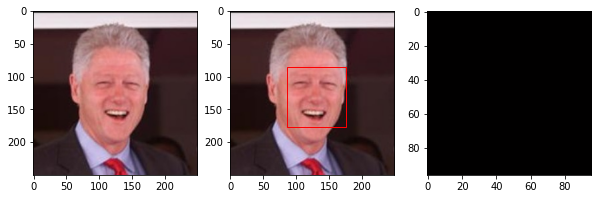

In [9]:
show_original_and_aligned(11)